# Evaluate model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Setup

### Import packages

In [2]:
from fastai.vision import *

import IPython.display as ipd
from tqdm import tqdm_notebook

### Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [4]:
from pathlib import Path
import numpy as np

path_img = "../mfc_dataset_v2"
fnames = list(Path(path_img).rglob('*.jpg')) + list(Path(path_img).rglob('*.jpeg')) + list(Path(path_img).rglob('*.png'))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]


[PosixPath('../mfc_dataset_v2/female_3075.jpg'),
 PosixPath('../mfc_dataset_v2/male_3161.jpg'),
 PosixPath('../mfc_dataset_v2/male_4055.jpg'),
 PosixPath('../mfc_dataset_v2/male_5550.jpg'),
 PosixPath('../mfc_dataset_v2/female_3396.jpg')]

['female', 'male']


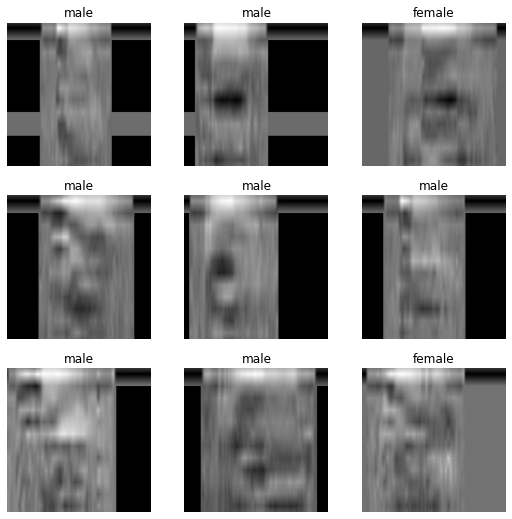

In [5]:
from fastai.vision.all import *
# Use DataBlock and DataLoaders instead of ImageDataBunch
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=RegexLabeller(pat)
)

dls = dblock.dataloaders(path_img, bs=64)
# Show batch and classes
dls.show_batch()
print(dls.vocab)
# You can use dls to train your model with cnn_learner, lr_find, fit_one_cycle, etc.


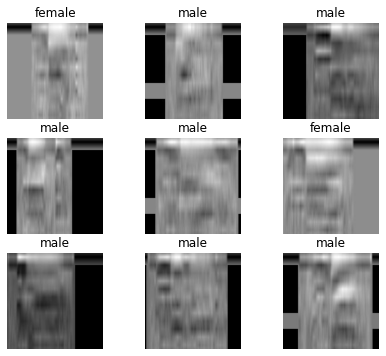

In [6]:
dls.show_batch(nrows=3, ncols=3, figsize=(7,6))


## Analyze mistakes

In [7]:
# learn = cnn_learner(dls, models.resnet34, metrics=error_rate)
# learn.model = load_learner(path_img).model
# # ClassificationInterpretation.from_learner requires the learn to has validation data.
# # However, load_learner(path_img) does not have validation data.
# # Therefore, I had to use the workaround above.

learn = cnn_learner(dls, models.resnet34, metrics=error_rate)

# Provide the correct file path to the exported learner file
learner_path = "vgg_model_step2.pkl"

# Load the learner model from the exported file
learn.model = load_learner(learner_path).model


/home/toandokhanh/.local/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [8]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)  # Assuming validation data is at index 1



In [ ]:
losses, idxs = interp.top_losses()  # only uses data from the validation set

bieu do loi

In [ ]:
# Plot the error graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
plt.title('Hệ số lỗi qua các mẫu trong tập validation')
plt.xlabel('Index mẫu')
plt.ylabel('Hệ số lỗi')
plt.show()

<div style="text-align: justify">
The outliers displayed as MFCs and the Grad-CAM heatmaps are not intuitive because we humans can't read off sounds from MFCs:
</div>

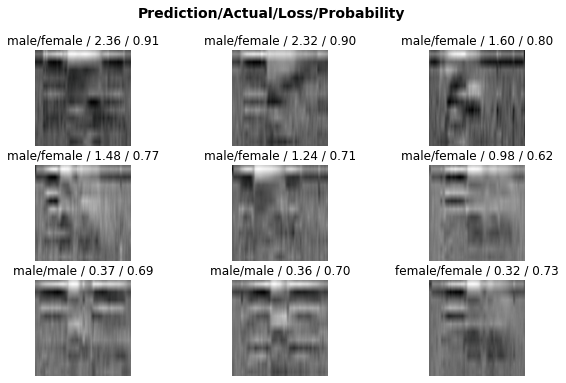

In [13]:
interp.plot_top_losses(9, figsize=(10, 6))

Instead, let's try hearing the top losses.

In [14]:
def load_json(json_fpath):
    with open(json_fpath, 'r') as json_f:
        return json.load(json_f)

In [15]:
male_idxs_to_wav_fpaths   = load_json('../maps/male_idxs_to_wav_fpaths_vgg16.json')
female_idxs_to_wav_fpaths = load_json('../maps/female_idxs_to_wav_fpaths_vgg16.json')

FileNotFoundError: [Errno 2] No such file or directory: '../maps/male_idxs_to_wav_fpaths_vgg16.json'

In [16]:
for idx in idxs[:5]:
    item = dls.valid_ds.items[idx]
    print(item, end='|')
    
    # Extracting audio file path based on your data structure
    wav_fpath = (
        female_idxs_to_wav_fpaths[str(item)] 
        if 'female' in str(item) 
        else male_idxs_to_wav_fpaths[str(item)]
    )
    
    print(wav_fpath)
    ipd.display(ipd.Audio(wav_fpath))

../mfc_dataset_v2/female_2656.jpg|

NameError: name 'female_idxs_to_wav_fpaths' is not defined

### Confusion matrix

The confusion matrix and the F1 score are commonly used to evaluate classifiers:

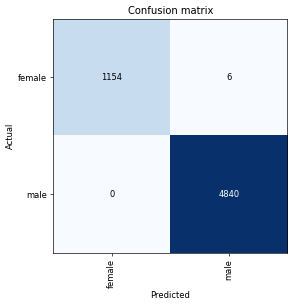

In [17]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

### F1 score

Since this is a binary classification task, we can think of "female" as "true" and "male as "false".

result

In [ ]:
cmat = interp.confusion_matrix()
precision = cmat[0][0] / (cmat[0][0] + cmat[1][0])  # true positives / (true positives + false positives = positive predictions) 
recall = cmat[0][0] / (cmat[0][0] + cmat[0][1])  # true positives / (true positives + false negatives = positive ground truths)
f1_score = 2 / (1 / precision + 1 / recall)
accuracy = (cmat[0][0] + cmat[1][1]) / (cmat[0][0] + cmat[0][1] + cmat[1][0] + cmat[1][1])

In [20]:
f1_score

0.9974070872947277

In [21]:
recall

0.9948275862068966

In [22]:
precision

1.0

In [26]:
accuracy

0.999